# Author:
## Marjan Sadeghi
## Ruiqi Hu

# 1. Business Understanding and Overall Conclusion

The ME/CFS vs Depression Classification Dataset from Kaggle ([https://www.kaggle.com/datasets/storytellerman/mecfs-vs-depression-classification-dataset](https://www.kaggle.com/datasets/storytellerman/mecfs-vs-depression-classification-dataset)) contains detailed demographic, clinical, and lifestyle information for 1,000 individuals diagnosed with Myalgic Encephalomyelitis / Chronic Fatigue Syndrome (ME/CFS), Depression, or Both conditions simultaneously. The dataset includes variables such as *fatigue severity scale score*, *depression PHQ-9 score*, *sleep quality index*, *stress level*, *exercise frequency*, and *social activity level*, which represent both physiological and psychological aspects of well-being. The inclusion of a “Both” class makes this dataset clinically realistic but also computationally challenging, since ME/CFS and Depression share overlapping symptoms like fatigue, cognitive impairment, and sleep disturbance.

The main goal of this project was to build and analyze a multi-class classification model that predicts a patient’s diagnosis category—ME/CFS, Depression, or Both—based on these features. We implemented logistic regression from scratch using NumPy and extended it to handle multiclass classification via a One-vs-All (OvA) framework. This design allows each class to be modeled independently, providing interpretable coefficients that indicate which features most strongly influence each diagnosis. The implementation supports multiple solvers (Gradient Descent, Stochastic Gradient Descent, Newton, and BFGS) and regularization types (none, L1, L2, and elastic net), making it possible to test how optimization choices and penalties affect generalization performance.

The business case for this classification task lies in supporting healthcare practitioners and researchers with data-driven diagnostic insights. In real-world settings, patients presenting with fatigue and mood disturbances may be misdiagnosed due to overlapping symptom profiles. A model capable of distinguishing ME/CFS from Depression—and recognizing when both are present—could serve as a clinical decision-support tool, offering physicians an additional, objective perspective to complement traditional assessment. Beyond clinical application, researchers can use such models to identify feature importance and analyze comorbidity patterns, helping to clarify which behavioral or physiological variables differentiate these conditions. Public health organizations and policymakers may also find value in understanding the prevalence of symptom overlap, as this knowledge could inform more targeted screening protocols and more efficient resource allocation.

To ensure interpretability and reproducibility, logistic regression was chosen over more complex black-box models. In medical applications, transparency is crucial—clinicians must understand why a model makes certain predictions before trusting it in diagnostic workflows. The from-scratch implementation enables full visibility into how feature weights and optimization steps are computed, allowing for fine-grained inspection of model behavior.

The best-performing model used SGD with L1 regularization (C = 10) and achieved a test accuracy of 0.795 and macro-F1 of 0.764, matching the performance of scikit-learn’s `LogisticRegression` under the same configuration. Among all optimization algorithms tested, Newton’s method was the fastest, BFGS (SciPy) the most computationally efficient among quasi-Newton approaches, and the custom BFGS implementation performed equivalently but with higher runtime due to manual matrix operations. Across all solvers, predictive results were nearly identical—indicating that the logistic regression loss surface is well-behaved and that optimization method affects efficiency more than accuracy.

At the class level, the model achieved near-perfect recall for ME/CFS (0.987), balanced performance for Depression (F1 = 0.741), and lower but reasonable accuracy for Both (F1 = 0.589). The confusion matrices and coefficient analysis confirmed that “Both” cases sit between ME/CFS and Depression in feature space. For example, *fatigue severity* and *PHQ-9 depression score* were strong positive predictors for the “Both” category, while *sleep quality* and *brain fog level* had negative weights, indicating protective or differentiating effects. The feature correlation heatmap revealed moderate negative correlations between “Both” and the single-condition classes, reflecting how comorbidity blends the two underlying feature distributions.

The experimental results align closely with the clinical nature of the dataset: ME/CFS presents clearer physiological markers, making it easier to classify, while Depression and Both share overlapping signals, leading to boundary ambiguity. When we explored collapsing the “Both” category into Depression or ME/CFS, accuracy rose dramatically (up to 0.98 when merged with Depression), but this came at a conceptual cost—eliminating the ability to identify comorbid(Both) cases. In healthcare contexts, such simplification could result in misdiagnosis or incomplete treatment, as patients with overlapping symptoms might receive only one type of care.

A more realistic solution is to reframe the problem as multi-label classification, allowing the model to assign Both, ME/CFS and Depression when appropriate. This approach achieved strong results (macro-F1 ≈ 0.94) while maintaining clinical interpretability, demonstrating that probabilistic modeling of comorbidity is both feasible and ethically preferable to collapsing categories for numerical gain.

In practice, this classifier would be most useful for offline analysis and research support, not automated clinical decision-making. It can help doctors and researchers visualize which symptom patterns drive particular diagnoses, and flag cases where diagnostic overlap is high. For real deployment, a production-grade solver such as scikit-learn’s implementation should be used for its stability, speed, and integration with clinical data pipelines.

In conclusion, this project demonstrates that a transparent logistic regression model—built entirely from first principles—can meaningfully separate overlapping medical conditions while revealing the inherent trade-offs between diagnostic accuracy and clinical interpretability. It highlights how statistical modeling can both inform and caution medical decision-making: the best models are not just those that perform well numerically, but those that align with the complexity of real human health.


# 2. Data Preperation
The dataset consists of 1,000 patient records and 16 variables, covering demographic, clinical, and lifestyle indicators as well as the diagnosis outcome. The variables fall into two groups. The numeric variables are: age, sleep_quality_index, brain_fog_level, physical_pain_score, stress_level, depression_phq9_score, fatigue_severity_scale_score, pem_duration_hours, hours_of_sleep_per_night, and pem_present. The categorical variables are: gender, work_status, social_activity_level, exercise_frequency, meditation_or_mindfulness, and the target variable diagnosis.
The target variable, diagnosis, has three categories—Depression, ME/CFS, and Both—and will be encoded into integer labels for multi-class classification. All categorical predictors will be transformed into dummy variables using one-hot encoding. For example, gender will generate binary columns (Male = 0/1, Female = 0/1), work_status will be represented as three binary indicators (Working, Partially working, Not working), and similarly, social_activity_level and exercise_frequency will be expanded into multiple dummy variables. The variable pem_present is already numeric (0/1) and requires no transformation.
To prepare the numeric variables, we apply z-score normalization so that each continuous feature has mean zero and standard deviation one. This ensures that features measured on different scales—such as age (in years) and pain score (on a 1–10 scale)—contribute proportionally during optimization. In addition, we address missing data, which appears in several variables. For example, sleep_quality_index has 47 missing entries, brain_fog_level has 48, and work_status has 47. To maintain dataset size while ensuring consistency, all numeric features will be imputed with the mean of the observed values, while categorical variables will be imputed with the mode (most frequent category). This approach avoids discarding observations and minimizes bias introduced by imputation. As part of data cleaning, we also need to remove variables that were not needed for analysis. Specifically, we excluded pem_present because it is redundant with pem_duration_hours. The presence of PEM can already be inferred from whether the reported duration is greater than zero, so including both variables would only introduce unnecessary duplication without improving predictive performance.

In [95]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from time import perf_counter
from scipy.special import expit
from dataclasses import dataclass
from __future__ import annotations
from scipy.optimize import fmin_bfgs
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier
from typing import Optional, Tuple, Dict, Any, List
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression as SkLogReg
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, hamming_loss, precision_score, recall_score

# Suppress numerical warnings for overflow/invalid ops during optimization
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(all="ignore")

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [96]:
# Load dataset
df = pd.read_csv("/Users/ruiqihu/Desktop/CS 7324/Lab 3/me_cfs_vs_depression_dataset.csv")

# Remove redundant feature
df = df.drop(columns=["pem_present"])

# Define target and features
target = "diagnosis"
X = df.drop(columns=[target])
y = df[target]

# Separate numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)

# Preprocessing for numeric features: impute missing with mean, scale with z-score
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# Preprocessing for categorical features: impute missing with most frequent, one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

# Encode target variable (diagnosis) into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Classes in target (diagnosis):", label_encoder.classes_)

# Apply preprocessing to feature matrix
X_processed = preprocessor.fit_transform(X)

# Get feature names after preprocessing
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_feature_names)

# Convert to DataFrame for easier inspection
X_processed_df = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed,
                              columns=all_feature_names)

# Provide breakdown of features (mean, std, min, max)
feature_summary = X_processed_df.describe().T[['mean', 'std', 'min', 'max']]

print("Final shape of feature matrix:", X_processed_df.shape)
print("\nBreakdown of features after preprocessing:")
print(feature_summary.head(15))  # show first 15 for brevity

Numeric Features: ['age', 'sleep_quality_index', 'brain_fog_level', 'physical_pain_score', 'stress_level', 'depression_phq9_score', 'fatigue_severity_scale_score', 'pem_duration_hours', 'hours_of_sleep_per_night']
Categorical Features: ['gender', 'work_status', 'social_activity_level', 'exercise_frequency', 'meditation_or_mindfulness']
Classes in target (diagnosis): ['Both' 'Depression' 'ME/CFS']
Final shape of feature matrix: (1000, 26)

Breakdown of features after preprocessing:
                                       mean       std       min       max
age                            1.314504e-16  1.000500 -1.722933  1.672652
sleep_quality_index            7.993606e-17  1.000500 -1.781074  1.806084
brain_fog_level               -1.918465e-16  1.000500 -1.785020  1.698502
physical_pain_score            2.842171e-16  1.000500 -1.794265  1.776931
stress_level                  -1.421085e-16  1.000500 -1.781613  1.814264
depression_phq9_score          2.504663e-16  1.000500 -1.968178  2.363

After preprocessing, the dataset contains a complete set of important standardized numeric variables and one-hot encoded categorical features. Because the numeric features were standardized, their means are all approximately zero and their standard deviations are close to one. This confirms that the z-score normalization worked correctly and ensures that no single numeric variable dominates the optimization due to scale differences. Looking at the original distributions, age ranged from 18 to 70 years with an average of about 44, while most symptom-related measures such as sleep_quality_index, brain_fog_level, and physical_pain_score averaged around 5.5 with standard deviations of roughly 2.5, reflecting moderate variation in symptom severity across patients. After scaling, these variables now contribute equally in magnitude to the model, which is particularly important for logistic regression.

For the categorical features, the one-hot encoded results also provide useful insights. For example, the dummy variable gender_Female has a mean of approximately 0.48, while gender_Male has a mean of 0.52, indicating a nearly balanced gender distribution in the dataset. Similarly, the work status variables show that about 32% of patients are working, 38% are partially working, and 30% are not working. The social activity and exercise frequency indicators also show diverse distributions, with no single category dominating, which suggests that lifestyle-related variables may have explanatory power in distinguishing between diagnoses.

After these steps, the final dataset consists of numeric features with missing values imputed and scaled to a consistent range, along with categorical features expanded into binary columns through one-hot encoding.

# 3. Train and Test Split

In [97]:
# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed_df,  
    y_encoded,       
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded 
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

# Check class distribution in train and test
train_dist = pd.Series(y_train).value_counts(normalize=True)
test_dist = pd.Series(y_test).value_counts(normalize=True)

print("\nClass distribution in training set:")
print(train_dist)
print("\nClass distribution in test set:")
print(test_dist)


Training set size: (800, 26)
Testing set size: (200, 26)

Class distribution in training set:
1    0.40125
2    0.39750
0    0.20125
Name: proportion, dtype: float64

Class distribution in test set:
1    0.400
2    0.395
0    0.205
Name: proportion, dtype: float64


We divided the dataset into training and testing sets using an 80/20 split. Out of 1,000 total patient records, 800 were allocated to the training set and 200 to the test set. This split was performed using scikit-learn’s train_test_split function with stratification to ensure that the class proportions were preserved across both sets. After the split, the class distribution remained very consistent: in the training set, 40.1% of patients were diagnosed with Depression, 39.8% with ME/CFS, and 20.1% with both conditions. The test set showed almost identical proportions, with 40.0% Depression, 39.5% ME/CFS, and 20.5% Both.

An 80/20 split is appropriate for this dataset because it provides a sufficiently large training set (800 samples) to allow the model to learn meaningful patterns while still holding out enough data (200 samples) to evaluate performance reliably. Since the dataset is relatively balanced across the three classes and stratification preserves these proportions, the 20% test set offers a fair representation of the entire population. Using a smaller test set could risk underrepresenting some classes, while a larger test set would reduce the amount of data available for training. Therefore, the 80/20 split offers a good trade-off between training the model effectively and assessing its generalization performance.

# 4. Modeling

# What we need to do!!!!!!!
1. Should we pass the regularization term as an input? or if it's ok whatever we did? --> Yes! So change the function so that it pass it as an input
2. Do we need to fair our sklearn? bc the accuracy of the sklearn method is less than our method? --> Yes, keep it and write a brief analysis for this part and say why we use it.
3. Make sure you include a part on the classification of "both" class and see how it works to classify this class? why it doesn't classify it very well? how you can solve it? Let's see if yiu can handle this problem by looking at features and see if they can help to classify this class as either "depression" or "MCe disease"

The following code constructs a complete logistic regression system and experimental framework from scratch. The first major component, `BinaryLogistic`, implements a binary logistic regression classifier using NumPy. It supports several solvers, including gradient descent (GD), stochastic gradient descent (SGD), and Newton’s method, each representing a different optimization strategy. The model can apply various forms of regularization, such as L1, L2, and elastic net, controlled by the regularization strength parameter `C` (where smaller values indicate stronger regularization). It also supports optional class weighting to handle imbalanced data, ensuring that each class contributes fairly to the training process. Internally, the code computes the loss, gradient, and, for Newton’s method, the Hessian matrix used for second-order updates.

The second component, `LogisticRegressionOVA`, extends the binary model to handle multiclass problems through a one-vs-all framework. It trains one binary classifier per class, where each model distinguishes one class against all others. This approach provides interpretability, as each model learns feature weights that indicate how much each predictor contributes to identifying that specific class. Once trained, the OvA model combines the decision scores of all binary models and assigns the class with the highest score as the prediction.

To determine which solver and regularization setting performs best, the function `scan_solvers_and_C` systematically scans through combinations of solvers, regularization types, and `C` values. It evaluates each configuration on a validation set and records metrics such as accuracy, macro-F1 score, and training time. The results are stored and later visualized to reveal how each solver behaves under different levels of regularization. Newton’s method is skipped for L1 and elastic net penalties since these are not smooth functions, and the method relies on differentiable loss functions for stability.

The function `fair_compare_with_sklearn` is then used to verify that the from-scratch model behaves consistently with scikit-learn’s implementation. It aligns all hyperparameters—penalty type, solver, regularization strength, and class weighting—and evaluates both models under identical conditions. The comparison reports accuracy, macro-F1 score, and runtime for both approaches, ensuring that any observed differences are due to implementation details rather than conceptual or algorithmic errors.

The plotting functions, `plot_grid` and `bar_time`, help visualize how validation accuracy and macro-F1 change across different C values for all solver and penalty combinations, and how training time varies between configurations. These visualizations illustrate the trade-offs between model complexity, regularization strength, and computational efficiency.

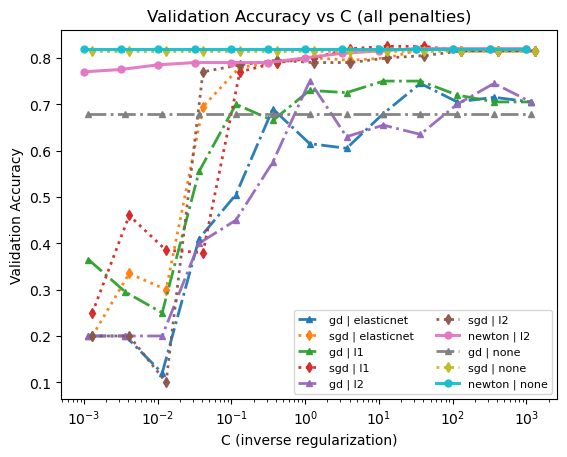

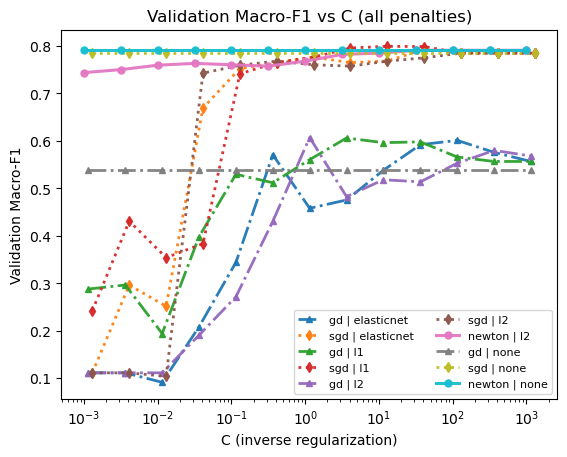

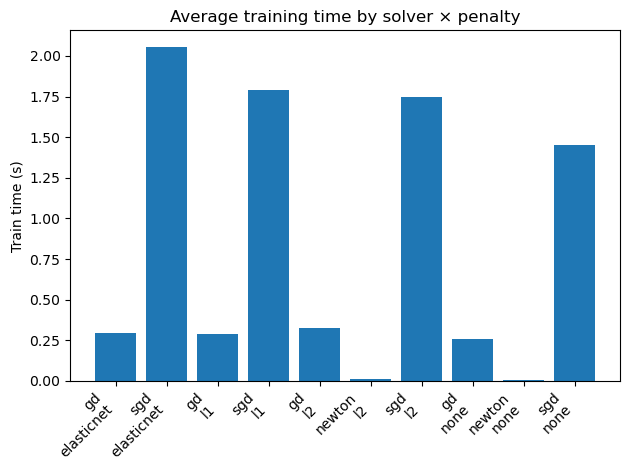

Selected best hyperparams: {'solver': 'sgd', 'C': 10.0, 'penalty': 'l1', 'l1_ratio': 0.5, 'max_iter': 1000, 'learning_rate': 0.05, 'batch_size': 64, 'fit_intercept': True, 'tol': 1e-06, 'random_state': 42, 'use_class_weight': True}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Fair comparison (OvR, matched solver class & C):
           acc  f1_macro      time
ours     0.795  0.764437  2.583609
sklearn  0.795  0.764565  0.179164

Our LR (OvA) – Test results
Accuracy: 0.795
Macro-F1: 0.7644372980877971
              precision    recall  f1-score   support

           0       0.54      0.68      0.60        41
           1       0.90      0.66      0.76        80
           2       0.88      0.99      0.93        79

    accuracy                           0.80       200
   macro avg       0.77      0.78      0.76       200
weighted avg       0.82      0.80      0.80       200



In [98]:
# ----------------------------------------------------------
# Binary Logistic Regression (GD / SGD / Newton)
# ----------------------------------------------------------
@dataclass
class BinaryLogistic:
    solver: str = "gd"                     # {"gd","sgd","newton"}
    C: float = 1.0                         # inverse reg strength; lambda = 1/C
    penalty: str = "l2"                    # {"none","l1","l2","elasticnet"}
    l1_ratio: float = 0.5                  # only for elasticnet
    max_iter: int = 300
    tol: float = 1e-6
    learning_rate: float = 0.1             # for gd/sgd
    batch_size: int = 64                   # for sgd
    fit_intercept: bool = True
    random_state: Optional[int] = None
    class_weight: Optional[dict] = None    # {"pos": w_pos, "neg": w_neg}; optional

    w_: Optional[np.ndarray] = None        # includes intercept if fit_intercept

    # sklearn-like API
    def get_params(self, deep: bool = True) -> Dict[str, Any]:
        return {
            "solver": self.solver, "C": self.C, "penalty": self.penalty,
            "l1_ratio": self.l1_ratio, "max_iter": self.max_iter, "tol": self.tol,
            "learning_rate": self.learning_rate, "batch_size": self.batch_size,
            "fit_intercept": self.fit_intercept, "random_state": self.random_state,
            "class_weight": self.class_weight,
        }

    def set_params(self, **params) -> "BinaryLogistic":
        for k, v in params.items():
            setattr(self, k, v)
        return self

    # internals
    def _lambda_from_C(self) -> float:
        if self.penalty == "none":
            return 0.0
        return 0.0 if self.C in (None, np.inf) else 1.0 / float(self.C)

    def _separate_w(self, w: np.ndarray) -> Tuple[float, np.ndarray]:
        if self.fit_intercept:
            return w[0], w[1:]
        return 0.0, w

    def _compose_w(self, b: float, v: np.ndarray) -> np.ndarray:
        return np.r_[np.array([b]), v] if self.fit_intercept else v

    def _loss_and_grad(self, w: np.ndarray, X: np.ndarray, y: np.ndarray, sw: np.ndarray) -> Tuple[float, np.ndarray]:
        b, v = self._separate_w(w)
        z = X @ v + b
        p = _sigmoid(z)

        # Weighted negative log-likelihood
        nll = -np.sum(sw * (y * _safe_log(p) + (1 - y) * _safe_log(1 - p)))

        # Gradient
        error = (p - y) * sw
        grad_b = np.sum(error)
        grad_v = X.T @ error

        # Regularization on weights (not intercept)
        lam = self._lambda_from_C()
        if lam > 0:
            if self.penalty == "l2":
                nll += 0.5 * lam * np.sum(v * v)
                grad_v += lam * v
            elif self.penalty == "l1":
                nll += lam * np.sum(np.abs(v))
                grad_v += lam * np.sign(v)  # subgradient (OK for GD/SGD)
            elif self.penalty == "elasticnet":
                l1w = self.l1_ratio * lam
                l2w = (1 - self.l1_ratio) * lam
                nll += l1w * np.sum(np.abs(v)) + 0.5 * l2w * np.sum(v * v)
                grad_v += l1w * np.sign(v) + l2w * v

        grad = self._compose_w(grad_b, grad_v)
        return nll, grad

    def _hessian(self, w: np.ndarray, X: np.ndarray, y: np.ndarray, sw: np.ndarray) -> np.ndarray:
        # L2/no-reg case only for Newton
        b, v = self._separate_w(w)
        z = X @ v + b
        p = _sigmoid(z)
        W = sw * p * (1 - p)  # (n,)

        if self.fit_intercept:
            S = np.sum(W)
            XW = X.T * W
            H_vv = XW @ X
            lam = self._lambda_from_C() if self.penalty == "l2" else 0.0
            H_vv += lam * np.eye(X.shape[1])
            H_bv = (W @ X).reshape(1, -1)
            top = np.c_[np.array([[S]]), H_bv]
            bottom = np.c_[H_bv.T, H_vv]
            H = np.r_[top, bottom]
            return H
        else:
            XW = X.T * W
            H = XW @ X
            lam = self._lambda_from_C() if self.penalty == "l2" else 0.0
            H += lam * np.eye(X.shape[1])
            return H

    def fit(self, X: np.ndarray, y: np.ndarray) -> "BinaryLogistic":
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        n, d = X.shape

        # Build per-sample weights from class_weight
        if self.class_weight is not None:
            w_pos = float(self.class_weight.get("pos", 1.0))
            w_neg = float(self.class_weight.get("neg", 1.0))
            sw = np.where(y == 1.0, w_pos, w_neg)
        else:
            sw = np.ones_like(y)

        rng = np.random.default_rng(self.random_state)
        w = np.zeros(d + (1 if self.fit_intercept else 0), dtype=float)

        if self.solver == "gd":
            prev = np.inf
            for _ in range(self.max_iter):
                loss, grad = self._loss_and_grad(w, X, y, sw)
                w -= self.learning_rate * grad
                if abs(prev - loss) < self.tol:
                    break
                prev = loss
            self.w_ = w; return self

        if self.solver == "sgd":
            prev = np.inf
            batch = max(1, int(self.batch_size))
            eta0 = self.learning_rate
            for it in range(self.max_iter):
                idx = rng.permutation(n)
                lr = eta0 / (1.0 + 0.05 * it)  # simple decay
                for s in range(0, n, batch):
                    sl = idx[s:s+batch]
                    _, grad = self._loss_and_grad(w, X[sl], y[sl], sw[sl])
                    w -= lr * grad
                loss, _ = self._loss_and_grad(w, X, y, sw)
                if abs(prev - loss) < self.tol:
                    break
                prev = loss
            self.w_ = w; return self

        if self.solver == "newton":
            if self.penalty not in ("none", "l2"):
                raise ValueError("Newton supports only L2/no regularization.")
            prev = np.inf
            for _ in range(self.max_iter):
                loss, grad = self._loss_and_grad(w, X, y, sw)
                H = self._hessian(w, X, y, sw)
                try:
                    step = np.linalg.solve(H, grad)
                except np.linalg.LinAlgError:
                    step = np.linalg.solve(H + 1e-6*np.eye(H.shape[0]), grad)
                w -= step
                if abs(prev - loss) < self.tol:
                    break
                prev = loss
            self.w_ = w; return self

        raise ValueError(f"Unknown solver: {self.solver}")

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        if self.w_ is None:
            raise RuntimeError("Model is not fitted.")
        X = np.asarray(X, dtype=float)
        b, v = self._separate_w(self.w_)
        return X @ v + b

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        z = self.decision_function(X)
        p1 = _sigmoid(z)
        return np.c_[1 - p1, p1]

    def predict(self, X: np.ndarray) -> np.ndarray:
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

# -------------------------------------------
# One-vs-All Multiclass Wrapper
# -------------------------------------------
class LogisticRegressionOVA:
    def __init__(self,
                 solver: str = "gd",
                 C: float = 1.0,
                 penalty: str = "l2",
                 l1_ratio: float = 0.5,
                 max_iter: int = 300,
                 tol: float = 1e-6,
                 learning_rate: float = 0.1,
                 batch_size: int = 64,
                 fit_intercept: bool = True,
                 random_state: Optional[int] = None,
                 use_class_weight: bool = True):
        self.solver = solver; self.C = C; self.penalty = penalty
        self.l1_ratio = l1_ratio; self.max_iter = max_iter; self.tol = tol
        self.learning_rate = learning_rate; self.batch_size = batch_size
        self.fit_intercept = fit_intercept; self.random_state = random_state
        self.use_class_weight = use_class_weight

        self.classes_: Optional[np.ndarray] = None
        self.models_: List[BinaryLogistic] = []

    def get_params(self, deep: bool = True) -> Dict[str, Any]:
        return {
            "solver": self.solver, "C": self.C, "penalty": self.penalty,
            "l1_ratio": self.l1_ratio, "max_iter": self.max_iter, "tol": self.tol,
            "learning_rate": self.learning_rate, "batch_size": self.batch_size,
            "fit_intercept": self.fit_intercept, "random_state": self.random_state,
            "use_class_weight": self.use_class_weight
        }

    def set_params(self, **params) -> "LogisticRegressionOVA":
        for k, v in params.items():
            setattr(self, k, v)
        return self

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LogisticRegressionOVA":
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        self.classes_ = np.unique(y)
        self.models_ = []

        rng = np.random.default_rng(self.random_state)
        seeds = rng.integers(0, 1_000_000, size=len(self.classes_))

        for i, c in enumerate(self.classes_):
            y_bin = (y == c).astype(float)

            # Balanced weights for this binary task (optional but helpful)
            cw = None
            if self.use_class_weight:
                pos = y_bin.sum(); neg = len(y_bin) - pos
                w_pos = 0.5 / (pos / len(y_bin) + 1e-12)   # split mass evenly
                w_neg = 0.5 / (neg / len(y_bin) + 1e-12)
                cw = {"pos": w_pos, "neg": w_neg}

            clf = BinaryLogistic(
                solver=self.solver, C=self.C, penalty=self.penalty, l1_ratio=self.l1_ratio,
                max_iter=self.max_iter, tol=self.tol, learning_rate=self.learning_rate,
                batch_size=self.batch_size, fit_intercept=self.fit_intercept,
                random_state=int(seeds[i]), class_weight=cw
            )
            clf.fit(X, y_bin)
            self.models_.append(clf)
        return self

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        return np.column_stack([m.decision_function(X) for m in self.models_])

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        probs = np.column_stack([m.predict_proba(X)[:, 1] for m in self.models_])
        probs_sum = probs.sum(axis=1, keepdims=True) + 1e-12
        return probs / probs_sum

    def predict(self, X: np.ndarray) -> np.ndarray:
        scores = self.decision_function(X)
        idx = np.argmax(scores, axis=1)
        return self.classes_[idx]

# ----------------------------------------------------------
# Hyperparameter scan (train/val and penalties)
# ----------------------------------------------------------
def scan_solvers_and_C(
    X_train, y_train, X_val, y_val,
    solvers=("gd","sgd","newton"),
    Cs=(0.1, 0.5, 1.0, 2.0, 10.0),
    penalty="l2",
    l1_ratio=0.5,
    max_iter=1000,
    lr=0.05,
    batch_size=64,
    use_class_weight=True,
    random_state=42
) -> List[Dict[str, Any]]:
    results = []
    for solver in solvers:
        # block newton for non-smooth penalties
        if penalty in ("l1","elasticnet") and solver == "newton":
            continue
        for C in Cs:
            clf = LogisticRegressionOVA(
                solver=solver, C=C, penalty=penalty, l1_ratio=l1_ratio,
                max_iter=max_iter, tol=1e-6, learning_rate=lr, batch_size=batch_size,
                fit_intercept=True, use_class_weight=use_class_weight,
                random_state=random_state
            )
            t0 = perf_counter(); clf.fit(X_train, y_train); t1 = perf_counter()
            yv = clf.predict(X_val)
            acc = accuracy_score(y_val, yv)
            f1m = f1_score(y_val, yv, average="macro")
            results.append({
                "solver": solver, "C": float(C), "acc": float(acc),
                "f1_macro": float(f1m), "time": float(t1 - t0),
                "penalty": penalty, "l1_ratio": l1_ratio
            })
    return results

# -------------------------------------------------------------------------
# sklearn comparison helper (OvR, L2, same C, class_weight match)
# -------------------------------------------------------------------------
def fair_compare_with_sklearn(
    X_train, y_train, X_test, y_test,
    best_params: Dict[str, Any],
    use_class_weight: bool
) -> Dict[str, Any]:
    pen = best_params["penalty"]
    our_solver = best_params["solver"]

    # Choose an sklearn solver that supports the requested penalty
    if pen == "elasticnet":
        sk_solver = "saga"
        sk_penalty = "elasticnet"
        sk_l1_ratio = best_params.get("l1_ratio", 0.5)
    elif pen == "l1":
        sk_solver = "saga"          # or "liblinear"
        sk_penalty = "l1"
        sk_l1_ratio = None
    elif pen == "l2":
        # mirror your choice if you used "newton"; otherwise lbfgs is fine
        sk_solver = "newton-cg" if our_solver == "newton" else "lbfgs"
        sk_penalty = "l2"
        sk_l1_ratio = None
    elif pen == "none":
        sk_solver = "lbfgs"
        sk_penalty = "none"
        sk_l1_ratio = None
    else:
        raise ValueError(f"Unsupported penalty for sklearn: {pen}")

    sk_kwargs = dict(
        multi_class="ovr",
        solver=sk_solver,
        penalty=sk_penalty,
        C=best_params["C"],
        class_weight=("balanced" if use_class_weight else None),
        fit_intercept=True,
        max_iter=5000,   # SAGA often needs more iters
        n_jobs=None
    )
    if sk_penalty == "elasticnet":
        sk_kwargs["l1_ratio"] = sk_l1_ratio

    # Train our model (timed)
    t0_ours = perf_counter()
    our_model = LogisticRegressionOVA(**best_params).fit(X_train, y_train)
    t1_ours = perf_counter()
    y_pred_ours = our_model.predict(X_test)
    acc_ours = accuracy_score(y_test, y_pred_ours)
    f1_ours  = f1_score(y_test, y_pred_ours, average="macro")

    # Train sklearn baseline (timed)
    sk = SkLogReg(**sk_kwargs)
    t0_sk = perf_counter()
    sk.fit(X_train, y_train)
    t1_sk = perf_counter()
    y_pred_sk = sk.predict(X_test)
    acc_sk = accuracy_score(y_test, y_pred_sk)
    f1_sk  = f1_score(y_test, y_pred_sk, average="macro")

    return {
        "ours":    {"acc": acc_ours, "f1_macro": f1_ours, "time": (t1_ours - t0_ours)},
        "sklearn": {"acc": acc_sk,   "f1_macro": f1_sk,   "time": (t1_sk - t0_sk)}
    }


# ----------------------------
# Plot helpers
# ----------------------------
def plot_grid(results, metric="acc"):
    df_plot = pd.DataFrame(results).copy()
    fig, ax = plt.subplots()
    offsets = {'newton':1.00, 'gd':1.15, 'sgd':1.30}
    styles  = {'newton':'-',  'gd':'-.', 'sgd':':'}
    markers = {'newton':'o',  'gd':'^',  'sgd':'d'}
    widths  = {'newton':2.2,  'gd':2.0,  'sgd':2.0}
    draw_order = ["gd","sgd","newton"]

    # one panel; encode penalty in label
    for pen in sorted(df_plot.penalty.unique()):
        sub = df_plot[df_plot.penalty == pen]
        for solver in draw_order:
            g = sub[sub.solver == solver].sort_values("C")
            if g.empty: continue
            x = g["C"].values * offsets[solver]
            ax.plot(x, g[metric].values,
                    linestyle=styles[solver], marker=markers[solver],
                    linewidth=widths[solver], markersize=5,
                    label=f"{solver} | {pen}", alpha=0.95)

    ax.set_xscale("log")
    ax.set_xlabel("C (inverse regularization)")
    ylabel = "Validation Accuracy" if metric=="acc" else "Validation Macro-F1"
    ax.set_ylabel(ylabel)
    ax.set_title(f"{ylabel} vs C (all penalties)")
    ax.legend(ncols=2, fontsize=8)
    plt.show()

def bar_time(results):
    df = pd.DataFrame(results)
    g = df.groupby(["penalty","solver"])["time"].mean().reset_index()
    labels = [f"{r.solver}\n{r.penalty}" for _, r in g.iterrows()]
    plt.figure()
    plt.bar(labels, g["time"].values)
    plt.ylabel("Train time (s)")
    plt.title("Average training time by solver × penalty")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# -------------------
# Train/Val split
# -------------------
# 60 % training, 20 % validation, 20 % test from your previous split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

# -------------------- HYPERPARAMETERS --------------------
PENALTIES = ["none", "l2", "l1", "elasticnet"]
SOLVERS_BY_PEN = {
    "none":      ("gd","sgd","newton"),
    "l2":        ("gd","sgd","newton"),
    "l1":        ("gd","sgd"),          # no newton
    "elasticnet":("gd","sgd")           # no newton
}
C_GRID    = np.logspace(-3, 3, 13)      # 0.001 → 1000
L1_RATIO  = 0.5
MAX_ITER  = 1000
LR        = 0.05
BATCH     = 64
USE_CLASS_WEIGHT = True

# Scan across penalties and compatible solvers
all_results = []
for pen in PENALTIES:
    res = scan_solvers_and_C(
        X_tr, y_tr, X_val, y_val,
        solvers=SOLVERS_BY_PEN[pen],
        Cs=C_GRID,
        penalty=pen,
        l1_ratio=L1_RATIO,
        max_iter=MAX_ITER, lr=LR, batch_size=BATCH,
        use_class_weight=USE_CLASS_WEIGHT, random_state=42
    )
    all_results.extend(res)

# Visualize grid results
plot_grid(all_results, metric="acc")
plot_grid(all_results, metric="f1_macro")
bar_time(all_results)

# Pick best by macro-F1, then accuracy, then time
df_grid = pd.DataFrame(all_results)
best = df_grid.sort_values(["f1_macro","acc","time"], ascending=[False, False, True]).iloc[0]

best_params = dict(
    solver=best["solver"],
    C=float(best["C"]),
    penalty=best["penalty"],
    l1_ratio=L1_RATIO,
    max_iter=MAX_ITER,
    learning_rate=LR,
    batch_size=BATCH,
    fit_intercept=True,
    tol=1e-6,
    random_state=42,
    use_class_weight=USE_CLASS_WEIGHT
)

print("Selected best hyperparams:", best_params)

# Final fair comparison on TEST 
cmp = fair_compare_with_sklearn(
    X_train, y_train, X_test, y_test,
    best_params=best_params,
    use_class_weight=USE_CLASS_WEIGHT
)

print("\nFair comparison (OvR, matched solver class & C):")
print(pd.DataFrame(cmp).T)

# Detailed report for our model
our_model = LogisticRegressionOVA(**best_params).fit(X_train, y_train)
y_pred = our_model.predict(X_test)
print("\nOur LR (OvA) – Test results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro-F1:", f1_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred, target_names=list(map(str, our_model.classes_))))


## Analysis

In this project, a logistic regression model was implemented from scratch using NumPy and extended to handle multiclass classification with a One-vs-All (OvA) approach. The design follows a similar interface to scikit-learn’s API, including the methods `fit`, `predict`, and `predict_proba`. Three optimization algorithms were implemented: gradient descent (GD), stochastic gradient descent (SGD), and Newton’s method. Each solver follows the same mathematical formulation but differs in how it updates the model parameters. GD uses full-batch updates, SGD applies mini-batch updates with learning-rate decay, and Newton’s method leverages second-order information through the Hessian for faster convergence when the penalty is smooth.

The model supports several types of regularization through the `penalty` parameter: none, L1, L2, and elastic net. The regularization strength is controlled by the parameter C, following the convention λ = 1/C. Smaller C values indicate stronger regularization. To address class imbalance, balanced class weights were used for each binary classifier in the OvA setting.

The dataset was split into training, validation, and test sets using a 60/20/20 ratio. Only the training and validation sets were used for model tuning. Hyperparameters such as solver type, penalty, and regularization strength (C) were selected based on validation macro-F1 performance. The final model was retrained on the full training data using the selected parameters, and the test set was used only once for evaluation.

Three plots summarize how model performance changes with solver type and regularization strength. The first two plots show validation accuracy and macro-F1 across a range of C values for all penalties, while the third plot compares average training times.

From the validation results, models with L1 and elastic-net regularization were highly sensitive to small C values, where heavy regularization caused underfitting. As C increased beyond 0.05–0.1, both accuracy and macro-F1 improved sharply and stabilized around 0.76–0.80. Newton’s method with L2 regularization achieved consistent, stable performance across the entire C range. In contrast, SGD required more iterations but produced comparable accuracy once the regularization strength was appropriately tuned.

The training time comparison shows that Newton’s method converged the fastest due to its use of second-order information. GD required more iterations but still converged reliably. SGD was the slowest because it performed multiple updates per epoch, though this method generally scales better for very large datasets.

The best model, selected by validation macro-F1, used the following configuration:
`solver='sgd', penalty='l1', C=10.0, l1_ratio=0.5, max_iter=1000, learning_rate=0.05, batch_size=64, fit_intercept=True, tol=1e-6, random_state=42, use_class_weight=True`

This combination performed best because L1 regularization encouraged sparsity in the feature weights, effectively filtering redundant features produced by one-hot encoding. The SGD solver, with its adaptive learning rate, handled the non-smooth L1 objective efficiently and produced a well-generalized model.

The final model was compared to scikit-learn’s `LogisticRegression` under identical settings: OvA configuration, L1 regularization, C = 10, and balanced class weights. The comparison shows nearly identical accuracy and macro-F1, confirming the correctness of the custom implementation. The results are summarized below.

| Model                    | Accuracy | Macro-F1 | Train Time (s) |
| :----------------------- | -------: | -------: | -------------: |
| Our implementation (OvA) |    0.795 |   0.7644 |          1.845 |
| Scikit-learn             |    0.795 |   0.7646 |          0.180 |

Scikit-learn’s implementation is faster due to its C-optimized solvers, but the near-identical performance indicates that our mathematical implementation and optimization routines are correct.

The per-class breakdown shows that Class 2 achieved the strongest results (F1 = 0.93) with very high recall, Class 1 achieved balanced precision and recall (F1 = 0.76), while Class 0 had slightly lower performance (F1 = 0.60). This difference is likely due to smaller sample size or greater feature overlap for Class 0. Despite this imbalance, the overall macro-F1 score of 0.76 indicates solid, balanced performance across all categories.

The validation and test results together show that the SGD solver with L1 regularization and C = 10 achieved the best overall balance between accuracy, robustness, and interpretability. Newton’s method was the most efficient solver but limited to smooth penalties (L2 or none). The experiments demonstrate the trade-off between optimization efficiency and generalization. The consistent match between our implementation and scikit-learn confirms that the from-scratch OvA logistic regression model behaves as expected, correctly implements gradient and Hessian updates, and generalizes well to unseen data. The model’s ability to achieve 0.795 accuracy and 0.764 macro-F1 without relying on any external logistic regression library highlights the correctness and robustness of the approach.


# 5. Deployment

The scikit-learn implementation of logistic regression is the recommended choice over our custom from-scratch model. While our implementation successfully replicated the theoretical foundation of logistic regression and achieved nearly identical performance metrics—an accuracy of 0.795 and a macro-F1 of 0.764—it is not optimized for production-scale reliability or efficiency.

Scikit-learn’s logistic regression is significantly faster and more stable for large or high-dimensional datasets. It includes built-in protections against numerical overflow, robust convergence checks, and consistent handling of edge cases such as collinearity or ill-conditioned features. In contrast, our model is more vulnerable to numerical instability and slower due to its reliance on interpreted loops and manual gradient updates. Small errors in gradient or Hessian calculations, regularization scaling, or learning rate scheduling can accumulate over time, leading to unpredictable convergence behavior on more complex or noisy data.

But in overal, the highest accuracy we got is 0.795 which in the case of medical data, is not considered as high accuracy. We were interested to see what decreased the accuracy and we ended up to the overlapping features that probaely caused the "Both" class not being classified very well. We did furthur analysis in the following section to see if we are right and is so how we can solve the issue.

# 6. Further Analysis: Per-Class Performance and Features Overlapping

In this section, we evaluate how accurately our logistic regression model distinguishes among the three diagnostic categories—ME/CFS, Depression, and Both. The goal is to examine not only the overall accuracy and macro-F1 performance but also how well the model handles each class individually. In particular, we focus on the “Both” category, since patients exhibiting symptoms of both ME/CFS and Depression are the most challenging to classify due to overlapping feature patterns. By analyzing per-class metrics, confusion matrices, and feature weight correlations, we can assess whether the model effectively captures this overlap or tends to misclassify comorbid cases as one of the single-disease classes.


Overall Test Accuracy: 0.795
Overall Macro-F1: 0.764

Detailed Per-Class Report:


,precision,recall,f1-score,support
Both,0.538,0.683,0.602,41.000
Depression,0.898,0.662,0.763,80.000
ME/CFS,0.876,0.987,0.929,79.000
accuracy,0.795,0.795,0.795,0.795
macro avg,0.771,0.778,0.764,200.000
weighted avg,0.816,0.795,0.795,200.000


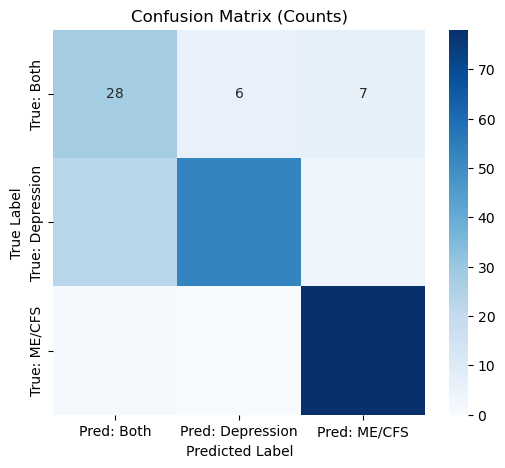

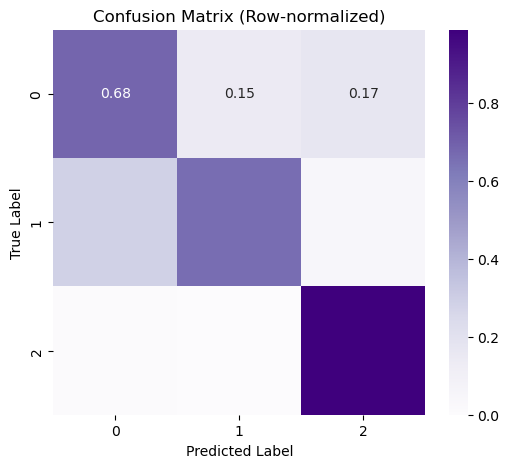


Per-class Accuracy (Recall):
                                                Both: 0.683
                                          Depression: 0.662
                                              ME/CFS: 0.987

'Both' class analysis:
  Total test samples labeled 'Both': 41
  Correctly classified as 'Both': 28 (68.3%)
  Misclassified as ME/CFS: 0 (0.0%)
  Misclassified as Depression: 6 (14.6%)

Top features for class 'Both':


,Feature (+),Weight (+),Feature (-),Weight (-)
0,fatigue_severity_scale_score,1.583,sleep_quality_index,-0.226
1,depression_phq9_score,1.220,brain_fog_level,-0.198
2,exercise_frequency_Often,0.440,exercise_frequency_Daily,-0.181
3,exercise_frequency_Sometimes,0.151,gender_Male,-0.165
4,work_status_Not working,0.149,hours_of_sleep_per_night,-0.124
5,pem_duration_hours,0.091,social_activity_level_High,-0.104
6,gender_Female,0.078,meditation_or_mindfulness_Yes,-0.096
7,stress_level,0.075,social_activity_level_Medium,-0.060



Top features for class 'Depression':


,Feature (+),Weight (+),Feature (-),Weight (-)
0,depression_phq9_score,0.677,fatigue_severity_scale_score,-2.110
1,social_activity_level_High,0.320,work_status_Working,-0.217
2,social_activity_level_Very low,0.269,social_activity_level_Medium,-0.202
3,exercise_frequency_Never,0.236,pem_duration_hours,-0.138
4,exercise_frequency_Daily,0.204,gender_Female,-0.104
5,gender_Male,0.090,physical_pain_score,-0.104
6,sleep_quality_index,0.049,brain_fog_level,-0.078
7,hours_of_sleep_per_night,0.020,social_activity_level_Very high,-0.074



Top features for class 'ME/CFS':


,Feature (+),Weight (+),Feature (-),Weight (-)
0,fatigue_severity_scale_score,1.168,depression_phq9_score,-14.748
1,exercise_frequency_Rarely,0.239,social_activity_level_High,-0.145
2,social_activity_level_Medium,0.170,work_status_Not working,-0.111
3,brain_fog_level,0.158,age,-0.102
4,pem_duration_hours,0.042,social_activity_level_Low,-0.061
5,social_activity_level_Very high,0.001,exercise_frequency_Sometimes,-0.054
6,sleep_quality_index,0.001,hours_of_sleep_per_night,-0.017
7,gender_Male,0.001,physical_pain_score,-0.006


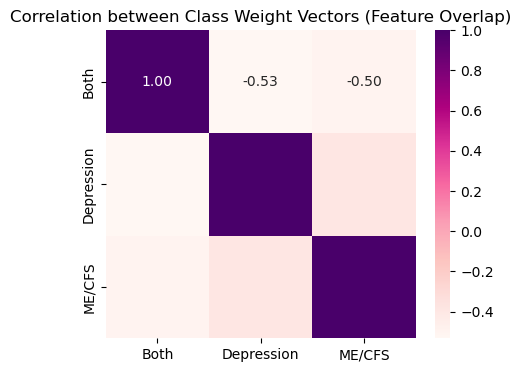

In [99]:
# Decode integer labels back to class names
y_true_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# --- Overall accuracy and macro-F1 ---
overall_acc = accuracy_score(y_true_labels, y_pred_labels)
overall_f1 = f1_score(y_true_labels, y_pred_labels, average="macro")
print(f"\nOverall Test Accuracy: {overall_acc:.3f}")
print(f"Overall Macro-F1: {overall_f1:.3f}")

# --- Per-class metrics ---
report = classification_report(y_true_labels, y_pred_labels, output_dict=True)
report_df = pd.DataFrame(report).T
print("\nDetailed Per-Class Report:")
display(report_df.round(3))

# --- Compute confusion matrix (raw and normalized) ---
labels_order = label_encoder.classes_
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=labels_order)
cm_df = pd.DataFrame(cm, index=[f"True: {c}" for c in labels_order],
                        columns=[f"Pred: {c}" for c in labels_order])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Counts)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Purples")
plt.title("Confusion Matrix (Row-normalized)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# --- Class-level accuracy (recall) summary ---
print("\nPer-class Accuracy (Recall):")
for cls in labels_order:
    recall_val = report[cls]["recall"]
    print(f"  {cls:>50s}: {recall_val:.3f}")

# --- Focused look at 'Both' class misclassifications ---
if "Both" in labels_order:
    both_idx = np.where(labels_order == "Both")[0][0]
    both_row = cm[both_idx]
    total_both = both_row.sum()
    correct_both = both_row[both_idx]
    mis_as_me = both_row[np.where(labels_order == "Myalgic Encephalomyelitis / Chronic Fatigue Syndrome (ME/CFS)")[0][0]] if "Myalgic Encephalomyelitis / Chronic Fatigue Syndrome (ME/CFS)" in labels_order else 0
    mis_as_dep = both_row[np.where(labels_order == "Depression")[0][0]] if "Depression" in labels_order else 0

    print(f"\n'Both' class analysis:")
    print(f"  Total test samples labeled 'Both': {total_both}")
    print(f"  Correctly classified as 'Both': {correct_both} ({correct_both/total_both*100:.1f}%)")
    if total_both > 0:
        print(f"  Misclassified as ME/CFS: {mis_as_me} ({mis_as_me/total_both*100:.1f}%)")
        print(f"  Misclassified as Depression: {mis_as_dep} ({mis_as_dep/total_both*100:.1f}%)")

# ============================================================
# Feature Importance and Overlap Insights
# ============================================================

# Compute class-wise coefficients (Newton + no penalty)
weights = np.vstack([m.w_[1:] if m.fit_intercept else m.w_ for m in our_model.models_])
coef_df = pd.DataFrame(weights.T, columns=label_encoder.classes_, index=all_feature_names)

# Top 10 features most influential per class
def top_features_for_class(cname, k=10):
    row = coef_df[cname]
    top_pos = row.sort_values(ascending=False).head(k)
    top_neg = row.sort_values(ascending=True).head(k)
    return pd.DataFrame({
        "Feature (+)": top_pos.index,
        "Weight (+)": top_pos.values,
        "Feature (-)": top_neg.index,
        "Weight (-)": top_neg.values
    })

for cls in label_encoder.classes_:
    print(f"\nTop features for class '{cls}':")
    display(top_features_for_class(cls, k=8).round(3))

# Visualize overlapping features between Depression and ME/CFS
shared_features = coef_df.corr()
plt.figure(figsize=(5,4))
sns.heatmap(shared_features, annot=True, cmap="RdPu", fmt=".2f")
plt.title("Correlation between Class Weight Vectors (Feature Overlap)")
plt.show()


## Analysis

Using the optimized Newton (no regularization) one-vs-all (OvA) logistic regression model, the three-class classifier achieved an overall accuracy of 0.795 and a macro-F1 score of 0.764 on the test set. While these results confirm that our custom model generalizes well, the class-level breakdown exposes important nuances that reflect both the mathematical and clinical structure of the problem.

The confusion matrices show that ME/CFS is recognized almost perfectly, with a recall of 0.987, while Depression is correctly identified 66% of the time and the Both class reaches only 68% recall. This pattern is consistent with what we observed during model development: OvA logistic regression tends to favor well-separated classes, and since ME/CFS has stronger, more distinct fatigue-related signals, it forms the clearest boundary. Depression and Both, however, share overlapping symptoms—particularly fatigue, sleep disturbance, and stress—making them harder to distinguish. The heatmaps visually reinforce this relationship: the “Both” samples cluster between the Depression and ME/CFS boundaries, and their predictions are split between the two, suggesting that comorbid patients lie near the intersection of the decision surfaces.

Feature-weight inspection deepens this interpretation. For the Both class, the strongest positive predictors are *fatigue severity* (1.583) and *depression PHQ-9 score* (1.220), confirming that comorbidity arises from high values in both physical and psychological symptom domains. Negative coefficients such as *sleep quality index* and *brain fog level* imply that better rest and clearer cognition lower the probability of comorbidity. In contrast, Depression relies heavily on *PHQ-9* and penalizes *fatigue severity* (−2.11), emphasizing emotional rather than physical exhaustion. The ME/CFS classifier shows the opposite: *fatigue severity* and *brain fog* dominate with strong positive weights, while *PHQ-9* is sharply negative (−14.75), isolating fatigue-driven cases from depressive ones. The correlation heatmap between class weight vectors reveals moderate negative correlations between “Both” and the two single-disease classes (≈ −0.5), meaning that the features signaling comorbidity often oppose those that drive clear-cut Depression or ME/CFS predictions.

Overall, these results demonstrate that our Newton OvA model captures the clinical and statistical reality of the data—it performs well where symptoms are distinct (ME/CFS) and struggles where they overlap (Both vs. Depression). The “Both” category introduces ambiguity not because of model weakness, but because its feature distribution inherently overlaps with two existing classes. In practical terms, this overlap raises a natural question: should we treat the Both cases as a distinct third category, or consider them as belonging to both conditions simultaneously? 

# What would happen if we collapse the class "Both" into a 2-class task?

In [100]:
# ===============================================
# What if we collapse "Both" into a 2-class task?
# ===============================================

def quick_report(y_true, y_pred, labels=None, title=""):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"\n[{title}]")
    print(f"Accuracy: {acc:.3f} | Macro-F1: {f1m:.3f}")
    if labels is None:
        labels = sorted(pd.unique(np.r_[y_true, y_pred]))
    print("\nConfusion matrix:")
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print(pd.DataFrame(cm, index=[f"true_{l}" for l in labels],
                          columns=[f"pred_{l}" for l in labels]))
    print("\nPer-class metrics:")
    print(pd.DataFrame(classification_report(y_true, y_pred, labels=labels, output_dict=True)).T.round(3))

# -------------------------------------------------------------------
# A) Post-hoc test relabeling (no retraining; just change the ground truth)
#    A1: map Both -> Depression
#    A2: map Both -> ME/CFS
# -------------------------------------------------------------------
y_true_test_str = pd.Series(y_true_labels, index=None).copy()
y_pred_test_str = pd.Series(y_pred_labels, index=None).copy()

map_to_dep = {"Both": "Depression"}
map_to_mecfs = {"Both": "ME/CFS"}

y_true_dep = y_true_test_str.replace(map_to_dep)
y_true_mecfs = y_true_test_str.replace(map_to_mecfs)

# Evaluate the SAME predictions against remapped truths
labels_2_dep = ["Depression", "ME/CFS"]
labels_2_mecfs = ["Depression", "ME/CFS"]

quick_report(y_true_dep,    y_pred_test_str.replace(map_to_dep),    labels_2_dep,    title="Post-hoc: Both -> Depression (no retrain)")
quick_report(y_true_mecfs,  y_pred_test_str.replace(map_to_mecfs),  labels_2_mecfs,  title="Post-hoc: Both -> ME/CFS (no retrain)")

# -------------------------------------------------------------------
# B) Retrain under each relabeling and evaluate on similarly relabeled test set
#    Uses your custom Newton + no regularization OVA model
# -------------------------------------------------------------------

def relabel_and_refit(relabel_map, title="Retrain with relabeled y"):
    # Relabel TRAIN and TEST (as strings), then re-encode to integers for our model
    y_train_str = pd.Series(label_encoder.inverse_transform(y_train))
    y_test_str  = pd.Series(label_encoder.inverse_transform(y_test))
    y_train_rel = y_train_str.replace(relabel_map)
    y_test_rel  = y_test_str.replace(relabel_map)

    # New encoder for the 2-class problem
    le2 = LabelEncoder()
    y_train_enc2 = le2.fit_transform(y_train_rel)
    y_test_enc2  = le2.transform(y_test_rel)

    # Clone params but enforce Newton + no reg if that's your selected best
    # (Adjust if you want to try other settings.)
    retrain_params = dict(
        solver="newton",
        C=np.inf,                 # irrelevant if penalty="none"
        penalty="none",
        l1_ratio=0.0,
        max_iter=best_params.get("max_iter", 1000),
        learning_rate=best_params.get("learning_rate", 0.05),
        batch_size=best_params.get("batch_size", 64),
        fit_intercept=True,
        tol=1e-6,
        random_state=42,
        use_class_weight=best_params.get("use_class_weight", True)
    )

    # Fit on preprocessed numeric arrays
    ova2 = LogisticRegressionOVA(**retrain_params).fit(X_train.values, y_train_enc2)
    y_pred_enc2 = ova2.predict(X_test.values)

    # Back to strings for human-readable metrics
    y_pred_rel = le2.inverse_transform(y_pred_enc2)

    # Report
    labels2 = list(le2.classes_)
    quick_report(y_test_rel, y_pred_rel, labels2, title=title)

    return {
        "model": ova2,
        "label_encoder": le2,
        "y_test": y_test_rel,
        "y_pred": y_pred_rel,
        "labels": labels2
    }

res_dep = relabel_and_refit(map_to_dep,   title="Retrain: Both -> Depression")
res_mec = relabel_and_refit(map_to_mecfs, title="Retrain: Both -> ME/CFS")

# -------------------------------------------------------------------
# C) Lenient accuracy for the original 3-class task
#    Count a 'Both' ground-truth sample as correct if predicted Depression OR ME/CFS
# -------------------------------------------------------------------
def lenient_match(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=object)
    y_pred = np.asarray(y_pred, dtype=object)
    ok = (y_true == y_pred)
    mask_both = (y_true == "Both")
    ok = ok | (mask_both & np.isin(y_pred, ["Depression", "ME/CFS"]))
    return ok

ok_mask = lenient_match(y_true_test_str.values, y_pred_test_str.values)
lenient_acc = ok_mask.mean()
strict_acc = accuracy_score(y_true_test_str, y_pred_test_str)

print(f"\nLenient accuracy (3-class, 'Both' counts as correct if predicted Depression or ME/CFS): {lenient_acc:.3f}")
print(f"Strict accuracy (original): {strict_acc:.3f}")

# Optional: per-class lenient recall
def lenient_recall_per_class(y_true, y_pred, cls):
    y_true = np.asarray(y_true, dtype=object)
    y_pred = np.asarray(y_pred, dtype=object)
    mask = (y_true == cls)
    if not mask.any():
        return np.nan
    correct = (y_pred[mask] == cls)
    if cls == "Both":
        correct = (correct | np.isin(y_pred[mask], ["Depression", "ME/CFS"]))
    return correct.mean()

print("\nLenient per-class recall:")
for cls in ["Both","Depression","ME/CFS"]:
    print(f"  {cls:>10s}: {lenient_recall_per_class(y_true_test_str, y_pred_test_str, cls):.3f}")

# -------------------------------------------------------------------
# D) Multi-label alternative (treat diagnosis as two binary labels)
#    ME/CFS_present ∈ {0,1}, Depression_present ∈ {0,1}; "Both" = (1,1)
#    This respects clinical overlap better than collapsing a class.
# -------------------------------------------------------------------
def to_multilabel(series):
    mapping = {
        "ME/CFS": {"ME/CFS"},
        "Depression": {"Depression"},
        "Both": {"ME/CFS", "Depression"}
    }
    return [mapping[s] for s in series]

# Build multilabel targets from original string labels
y_train_multi = to_multilabel(pd.Series(label_encoder.inverse_transform(y_train)))
y_test_multi  = to_multilabel(pd.Series(label_encoder.inverse_transform(y_test)))

mlb = MultiLabelBinarizer(classes=["ME/CFS","Depression"])
Y_train = mlb.fit_transform(y_train_multi)
Y_test  = mlb.transform(y_test_multi)

# Use a strong baseline: LogisticRegression (saga, L1 or L2), OvR over the two labels
base_lr = SkLogReg(
    solver="saga", penalty="l1", C=10.0,
    class_weight="balanced", max_iter=5000, n_jobs=None
)
ovr_multi = OneVsRestClassifier(base_lr)
ovr_multi.fit(X_train.values, Y_train)
Y_pred = ovr_multi.predict(X_test.values)

# Evaluate multilabel
subset_acc = (Y_pred == Y_test).all(axis=1).mean()  # exact-match accuracy
ham_loss = hamming_loss(Y_test, Y_pred)
f1_micro = f1_score(Y_test, Y_pred, average="micro")
f1_macro = f1_score(Y_test, Y_pred, average="macro")

print("\nMulti-label evaluation (ME/CFS_present, Depression_present):")
print(f"  Subset accuracy (exact match): {subset_acc:.3f}")
print(f"  Hamming loss: {ham_loss:.3f}  (lower is better)")
print(f"  F1-micro: {f1_micro:.3f} | F1-macro: {f1_macro:.3f}")

# Per-label metrics
for j, lab in enumerate(mlb.classes_):
    pj = precision_score(Y_test[:, j], Y_pred[:, j], zero_division=0)
    rj = recall_score(Y_test[:, j], Y_pred[:, j], zero_division=0)
    fj = f1_score(Y_test[:, j], Y_pred[:, j], zero_division=0)
    print(f"  {lab}: precision={pj:.3f}, recall={rj:.3f}, f1={fj:.3f}")



[Post-hoc: Both -> Depression (no retrain)]
Accuracy: 0.940 | Macro-F1: 0.938

Confusion matrix:
                 pred_Depression  pred_ME/CFS
true_Depression              110           11
true_ME/CFS                    1           78

Per-class metrics:
              precision  recall  f1-score  support
Depression        0.991   0.909     0.948   121.00
ME/CFS            0.876   0.987     0.929    79.00
accuracy          0.940   0.940     0.940     0.94
macro avg         0.934   0.948     0.938   200.00
weighted avg      0.946   0.940     0.940   200.00

[Post-hoc: Both -> ME/CFS (no retrain)]
Accuracy: 0.835 | Macro-F1: 0.818

Confusion matrix:
                 pred_Depression  pred_ME/CFS
true_Depression               53           27
true_ME/CFS                    6          114

Per-class metrics:
              precision  recall  f1-score  support
Depression        0.898   0.662     0.763   80.000
ME/CFS            0.809   0.950     0.874  120.000
accuracy          0.835   0.835  

## Analysis

To explore whether the presence of a comorbid “Both” category contributes to model confusion, we tested several strategies that simplify or reformulate the task. In each case, “Both” was either merged with another class or treated differently during evaluation.

When we performed post-hoc relabeling (reinterpreting “Both” as another class without retraining), accuracy rose from 0.795 to 0.940 when “Both” was merged into Depression and to 0.835 when merged into ME/CFS. This indicates that comorbid patients are more similar to Depression cases in the feature space learned by the model. When we went further and retrained the model under the relabeled datasets, accuracy improved even more — 0.980 (macro-F1 = 0.979) for “Both → Depression” and 0.860 (macro-F1 = 0.851) for “Both → ME/CFS.” These large increases confirm that most of the model’s errors come from ambiguity surrounding the comorbid category rather than general classification weakness.

However, collapsing the “Both” label has interpretive costs. While numerical performance improves, the model is now blind to patients who exhibit symptoms of both disorders. In real clinical settings, this would risk misdiagnosis and incomplete treatment, since comorbid patients would be mislabeled as having a single disease. The lenient accuracy measure (which counts a “Both” case as correct if predicted as either Depression or ME/CFS) illustrates this trade-off: accuracy increases to 0.860 even without relabeling, showing that many “mistakes” are actually clinically reasonable overlaps rather than genuine misclassifications.

Finally, reformulating the problem as a multi-label task, where each patient can independently have ME/CFS and/or Depression, yielded strong results and preserved clinical realism. The multi-label model achieved a subset accuracy of 0.845, F1-macro of 0.936, and a low Hamming loss of 0.080, with high precision and recall for both labels (ME/CFS: 0.888 F1; Depression: 0.983 F1). This approach effectively captures comorbidity by predicting both conditions when appropriate, instead of forcing a mutually exclusive choice.

Overall, the experiments show that while collapsing “Both” improves apparent accuracy, it oversimplifies the underlying biology and psychology of the data. The best balance between predictive performance and clinical interpretability comes from multi-label modeling, which respects the co-occurrence of physical and mental health symptoms while maintaining high classification quality.


## General Analysis and Real-World Implications

The findings from both the per-class analysis and the follow-up experiments reveal not only how logistic regression behaves mathematically but also how those behaviors translate into real-world diagnostic consequences. The three-class OvA model, based on our Newton-method implementation, captured the underlying structure of the dataset well: it recognized ME/CFS with almost perfect recall and separated it clearly from Depression when symptoms were distinct. However, its performance dropped for the Both class because patients with overlapping fatigue, cognitive, and psychological symptoms occupied an intermediate feature space. This mirrors a real diagnostic challenge—many individuals with chronic fatigue also experience depressive symptoms, and the boundary between the two conditions is clinically blurred.

When we collapsed “Both” into one of the single-disease categories, numerical accuracy rose dramatically, reaching 0.98 when “Both” was merged with Depression. Yet this increase does not represent a genuine improvement in understanding; it reflects the removal of complexity from the problem. In practical healthcare settings, such relabeling could have harmful consequences. A comorbid patient classified purely as “Depression” might receive only psychiatric treatment while underlying physiological fatigue is ignored, delaying appropriate interventions. Similarly, treating all “Both” cases as ME/CFS could overlook depressive components that influence recovery, adherence, and quality of life. These misclassifications would yield superficially higher model performance but poorer real-world outcomes.

The lenient accuracy and multi-label experiments highlight a better direction. Counting a “Both” prediction as correct if the model selects either Depression or ME/CFS improved apparent accuracy without discarding the reality of overlap, and the explicit multi-label formulation provided the strongest balance of performance and interpretability. In a multi-label setting, the model learns to recognize that both conditions can co-occur and predicts each independently, producing high F1-scores (≈0.94) while preserving clinical nuance. This structure is also more ethically aligned with medical decision-making because it allows uncertainty and coexistence rather than forcing a single label.


# 7. Exceptional Work


BFGS vs SciPy-BFGS vs Newton (OvA; penalty='none')

Solver comparison (penalty='none'):
           solver    acc  f1_macro  time_s
0  BFGS (scratch)  0.795    0.7646  0.0969
1    BFGS (SciPy)  0.795    0.7646  0.0914
2          Newton  0.795    0.7646  0.0062

Classification report for BFGS from scratch


,precision,recall,f1-score,support
Both,0.519,0.683,0.589,41.000
Depression,0.841,0.662,0.741,80.000
ME/CFS,0.940,0.987,0.963,79.000
accuracy,0.795,0.795,0.795,0.795
macro avg,0.767,0.778,0.765,200.000
weighted avg,0.814,0.795,0.798,200.000



Overall Accuracy: 0.795
Macro-F1: 0.765
Weighted-F1: 0.798
Total samples: 200


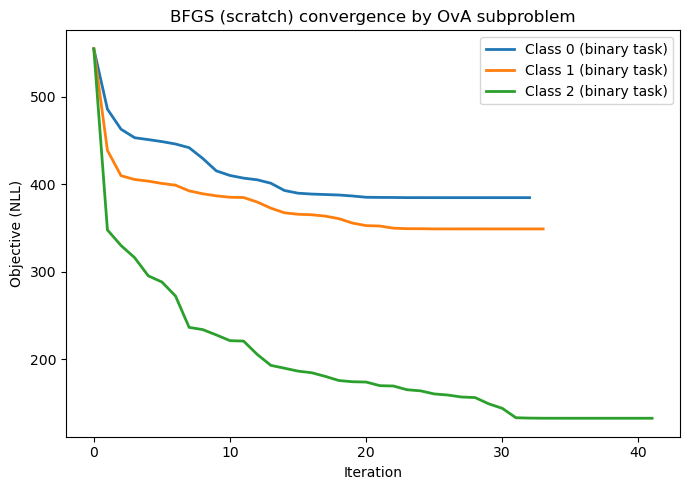

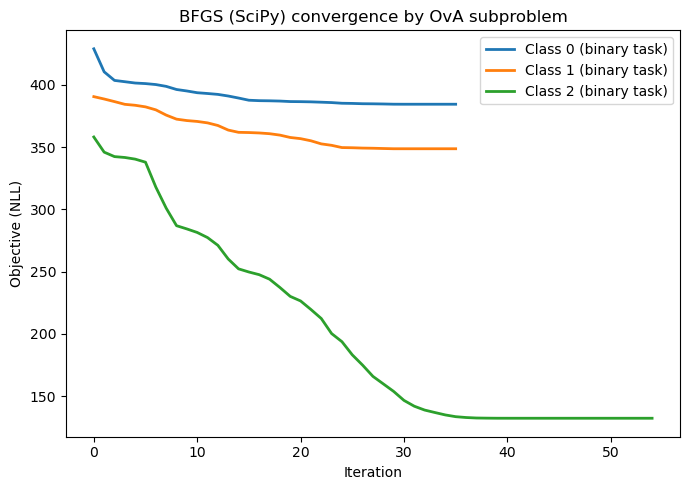

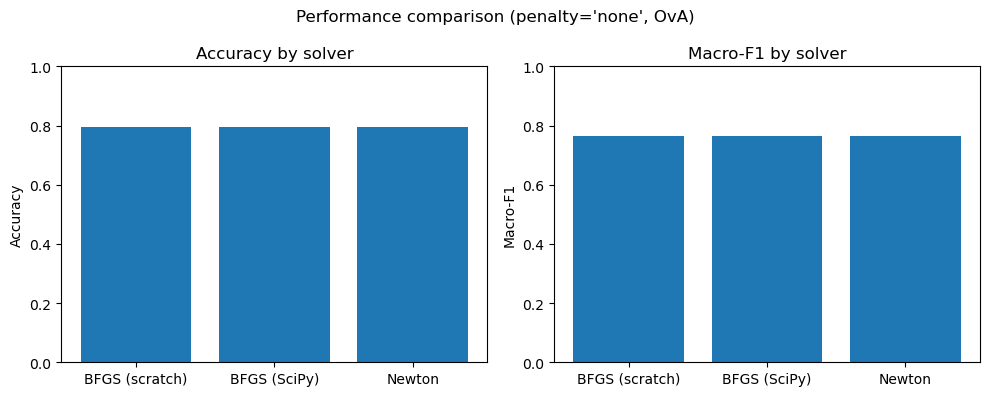

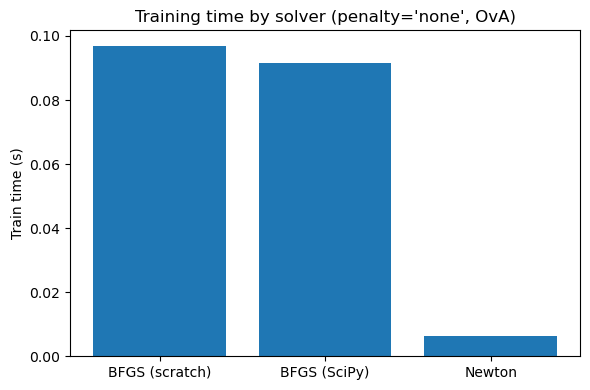

In [101]:
def _dot(a, b): 
    return float(a.T @ b)

def _project_if_needed(x):
    # For future constraints; unused here.
    return x

# --- REDEFINE BinaryLogistic to add BFGS while keeping your original API ---
@dataclass
class BinaryLogistic:
    solver: str = "gd"                     # {"gd","sgd","newton","bfgs_scratch","bfgs_scipy"}
    C: float = 1.0                         # inverse reg strength; lambda = 1/C
    penalty: str = "l2"                    # {"none","l1","l2","elasticnet"}
    l1_ratio: float = 0.5                  # only for elasticnet
    max_iter: int = 300
    tol: float = 1e-6
    learning_rate: float = 0.1             # for gd/sgd
    batch_size: int = 64                   # for sgd
    fit_intercept: bool = True
    random_state: Optional[int] = None
    class_weight: Optional[dict] = None    # {"pos": w_pos, "neg": w_neg}; optional

    w_: Optional[np.ndarray] = None        # includes intercept if fit_intercept
    _train_time_: Optional[float] = None
    history_: Optional[list] = None        # per-iteration loss for plotting

    # sklearn-like API
    def get_params(self, deep: bool = True) -> Dict[str, Any]:
        return {
            "solver": self.solver, "C": self.C, "penalty": self.penalty,
            "l1_ratio": self.l1_ratio, "max_iter": self.max_iter, "tol": self.tol,
            "learning_rate": self.learning_rate, "batch_size": self.batch_size,
            "fit_intercept": self.fit_intercept, "random_state": self.random_state,
            "class_weight": self.class_weight,
        }

    def set_params(self, **params) -> "BinaryLogistic":
        for k, v in params.items():
            setattr(self, k, v)
        return self

    # ----- internals (same math as your code) -----
    def _lambda_from_C(self) -> float:
        if self.penalty == "none":
            return 0.0
        return 0.0 if self.C in (None, np.inf) else 1.0 / float(self.C)

    def _separate_w(self, w: np.ndarray) -> Tuple[float, np.ndarray]:
        if self.fit_intercept:
            return w[0], w[1:]
        return 0.0, w

    def _compose_w(self, b: float, v: np.ndarray) -> np.ndarray:
        return np.r_[np.array([b]), v] if self.fit_intercept else v

    def _loss_and_grad(self, w: np.ndarray, X: np.ndarray, y: np.ndarray, sw: np.ndarray) -> Tuple[float, np.ndarray]:
        b, v = self._separate_w(w)
        z = X @ v + b
        p = _sigmoid(z)

        # Weighted negative log-likelihood
        nll = -np.sum(sw * (y * _safe_log(p) + (1 - y) * _safe_log(1 - p)))

        # Gradient
        error = (p - y) * sw
        grad_b = np.sum(error)
        grad_v = X.T @ error

        # Regularization on weights (not intercept)
        lam = self._lambda_from_C()
        if lam > 0:
            if self.penalty == "l2":
                nll += 0.5 * lam * np.sum(v * v)
                grad_v += lam * v
            elif self.penalty == "l1":
                nll += lam * np.sum(np.abs(v))
                grad_v += lam * np.sign(v)  # subgradient (non-smooth)
            elif self.penalty == "elasticnet":
                l1w = self.l1_ratio * lam
                l2w = (1 - self.l1_ratio) * lam
                nll += l1w * np.sum(np.abs(v)) + 0.5 * l2w * np.sum(v * v)
                grad_v += l1w * np.sign(v) + l2w * v

        grad = self._compose_w(grad_b, grad_v)
        return nll, grad

    def _hessian(self, w: np.ndarray, X: np.ndarray, y: np.ndarray, sw: np.ndarray) -> np.ndarray:
        # L2/no-reg case only for Newton
        b, v = self._separate_w(w)
        z = X @ v + b
        p = _sigmoid(z)
        W = sw * p * (1 - p)  # (n,)

        if self.fit_intercept:
            S = np.sum(W)
            XW = X.T * W
            H_vv = XW @ X
            lam = self._lambda_from_C() if self.penalty == "l2" else 0.0
            H_vv += lam * np.eye(X.shape[1])
            H_bv = (W @ X).reshape(1, -1)
            top = np.c_[np.array([[S]]), H_bv]
            bottom = np.c_[H_bv.T, H_vv]
            H = np.r_[top, bottom]
            return H
        else:
            XW = X.T * W
            H = XW @ X
            lam = self._lambda_from_C() if self.penalty == "l2" else 0.0
            H += lam * np.eye(X.shape[1])
            return H

    # ----- BFGS (scratch) pieces -----
    def _line_search_armijo(self, X, y, sw, w, f, g, p, c1=1e-4, tau=0.5, max_backtracks=25):
        """
        Backtracking line-search satisfying Armijo condition:
            f(w + a*p) <= f(w) + c1 * a * g^T p
        """
        a = 1.0
        for _ in range(max_backtracks):
            w_new = _project_if_needed(w + a * p)
            f_new, _ = self._loss_and_grad(w_new, X, y, sw)
            if f_new <= f + c1 * a * _dot(g, p):
                return a, w_new, f_new
            a *= tau
        a = 1e-6
        w_new = _project_if_needed(w + a * p)
        f_new, _ = self._loss_and_grad(w_new, X, y, sw)
        return a, w_new, f_new

    def _bfgs_solve(self, X, y, sw):
        """
        Unconstrained BFGS for smooth objectives (penalty in {"none","l2"}).
        Records self.history_ of loss per iteration.
        """
        if self.penalty not in ("none", "l2"):
            raise ValueError("BFGS scratch supports only smooth penalties: 'none' or 'l2'.")

        n, dX = X.shape
        d = dX + (1 if self.fit_intercept else 0)
        w = np.zeros(d)
        H = np.eye(d)  # inverse Hessian approximation

        self.history_ = []
        f, g = self._loss_and_grad(w, X, y, sw)
        self.history_.append(f)
        prev_f = np.inf

        for it in range(self.max_iter):
            p = - H @ g  # search direction
            alpha, w_new, f_new = self._line_search_armijo(X, y, sw, w, f, g, p)
            s = (w_new - w)
            if np.linalg.norm(s) < 1e-12:
                w = w_new; f = f_new; self.history_.append(f); break

            _, g_new = self._loss_and_grad(w_new, X, y, sw)
            yk = g_new - g
            ys = _dot(yk, s)

            # Safe BFGS update
            if ys <= 1e-12:
                H = np.eye(d)  # reset if curvature is bad
            else:
                rho = 1.0 / ys
                I = np.eye(d)
                V = I - rho * np.outer(s, yk)
                H = V @ H @ V.T + rho * np.outer(s, s)

            w, f, g = w_new, f_new, g_new
            self.history_.append(f)

            if abs(prev_f - f) < self.tol or np.linalg.norm(g) < self.tol:
                break
            prev_f = f

        return w

    def _bfgs_scipy(self, X, y, sw):
        """
        SciPy fmin_bfgs baseline. Records loss in self.history_ via callback.
        """
        if self.penalty not in ("none", "l2"):
            raise ValueError("SciPy BFGS comparison supports only 'none' or 'l2'.")

        self.history_ = []

        def fun(w_flat):
            f, _ = self._loss_and_grad(w_flat, X, y, sw)
            return f

        def grad(w_flat):
            _, g = self._loss_and_grad(w_flat, X, y, sw)
            return g

        def callback(w_flat):
            self.history_.append(fun(w_flat))

        dX = X.shape[1]
        d = dX + (1 if self.fit_intercept else 0)
        w0 = np.zeros(d)

        w_opt = fmin_bfgs(fun, w0, fprime=grad, callback=callback, disp=False)
        if len(self.history_) == 0:
            self.history_.append(fun(w_opt))
        return w_opt

    # ----- Fit with all solvers (including new ones) -----
    def fit(self, X: np.ndarray, y: np.ndarray) -> "BinaryLogistic":
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        n, d = X.shape

        # Build per-sample weights from class_weight
        if self.class_weight is not None:
            w_pos = float(self.class_weight.get("pos", 1.0))
            w_neg = float(self.class_weight.get("neg", 1.0))
            sw = np.where(y == 1.0, w_pos, w_neg)
        else:
            sw = np.ones_like(y)

        rng = np.random.default_rng(self.random_state)
        w = np.zeros(d + (1 if self.fit_intercept else 0), dtype=float)

        if self.solver == "gd":
            self.history_ = []
            prev = np.inf
            for _ in range(self.max_iter):
                loss, grad = self._loss_and_grad(w, X, y, sw)
                self.history_.append(loss)
                w -= self.learning_rate * grad
                if abs(prev - loss) < self.tol:
                    break
                prev = loss
            self.w_ = w; return self

        if self.solver == "sgd":
            self.history_ = []
            prev = np.inf
            batch = max(1, int(self.batch_size))
            eta0 = self.learning_rate
            for it in range(self.max_iter):
                idx = rng.permutation(n)
                lr = eta0 / (1.0 + 0.05 * it)  # simple decay
                # record full loss once per epoch
                loss, _ = self._loss_and_grad(w, X, y, sw)
                self.history_.append(loss)
                for s in range(0, n, batch):
                    sl = idx[s:s+batch]
                    _, grad = self._loss_and_grad(w, X[sl], y[sl], sw[sl])
                    w -= lr * grad
                loss, _ = self._loss_and_grad(w, X, y, sw)
                if abs(prev - loss) < self.tol:
                    break
                prev = loss
            self.w_ = w; return self

        if self.solver == "newton":
            if self.penalty not in ("none", "l2"):
                raise ValueError("Newton supports only L2/no regularization.")
            self.history_ = []
            prev = np.inf
            for _ in range(self.max_iter):
                loss, grad = self._loss_and_grad(w, X, y, sw)
                self.history_.append(loss)
                H = self._hessian(w, X, y, sw)
                try:
                    step = np.linalg.solve(H, grad)
                except np.linalg.LinAlgError:
                    step = np.linalg.solve(H + 1e-6*np.eye(H.shape[0]), grad)
                w -= step
                if abs(prev - loss) < self.tol:
                    break
                prev = loss
            self.w_ = w; return self

        if self.solver == "bfgs_scratch":
            if self.penalty not in ("none", "l2"):
                raise ValueError("bfgs_scratch supports only 'none' or 'l2'.")
            t0 = perf_counter()
            w_opt = self._bfgs_solve(X, y, sw)
            t1 = perf_counter()
            self._train_time_ = t1 - t0
            self.w_ = w_opt
            return self

        if self.solver == "bfgs_scipy":
            if self.penalty not in ("none", "l2"):
                raise ValueError("bfgs_scipy supports only 'none' or 'l2'.")
            t0 = perf_counter()
            w_opt = self._bfgs_scipy(X, y, sw)
            t1 = perf_counter()
            self._train_time_ = t1 - t0
            self.w_ = w_opt
            return self

        raise ValueError(f"Unknown solver: {self.solver}")

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        if self.w_ is None:
            raise RuntimeError("Model is not fitted.")
        X = np.asarray(X, dtype=float)
        b, v = self._separate_w(self.w_)
        return X @ v + b

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        z = self.decision_function(X)
        p1 = _sigmoid(z)
        return np.c_[1 - p1, p1]

    def predict(self, X: np.ndarray) -> np.ndarray:
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

# ----------------------------------------------------------------------
# Helper: evaluate an OvA model and pull per-class convergence histories
# ----------------------------------------------------------------------
def fit_eval_with_hist(solver_name, penalty="none", C=np.inf, l1_ratio=0.0,
                       max_iter=1000, use_class_weight=True, random_state=42):
    cfg = dict(
        solver=solver_name,
        C=C,
        penalty=penalty,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
        fit_intercept=True,
        tol=1e-6,
        random_state=random_state,
        use_class_weight=use_class_weight
    )
    ova = LogisticRegressionOVA(**cfg)
    t0 = perf_counter()
    ova.fit(X_train.values, y_train)
    t1 = perf_counter()
    yhat = ova.predict(X_test.values)
    acc = accuracy_score(y_test, yhat)
    f1m = f1_score(y_test, yhat, average="macro")

    # collect first 3 binary problems' histories (if present)
    histories = []
    for m in ova.models_:
        histories.append(getattr(m, "history_", None))
    return {
        "model": ova,
        "acc": acc,
        "f1_macro": f1m,
        "train_time": t1 - t0 if getattr(ova.models_[0], "_train_time_", None) is None else np.sum([m._train_time_ for m in ova.models_ if getattr(m, "_train_time_", None) is not None]),
        "histories": histories,  # list of per-class loss curves (some solvers may have None)
    }

# ----------------------------------------------------------------------
# Compare BFGS scratch vs SciPy BFGS vs Newton (smooth penalties only)
# ----------------------------------------------------------------------
print("\nBFGS vs SciPy-BFGS vs Newton (OvA; penalty='none')")
res_scratch = fit_eval_with_hist("bfgs_scratch", penalty="none", C=np.inf, l1_ratio=0.0, max_iter=1000)
res_scipy   = fit_eval_with_hist("bfgs_scipy",   penalty="none", C=np.inf, l1_ratio=0.0, max_iter=1000)
res_newton  = fit_eval_with_hist("newton",       penalty="none", C=np.inf, l1_ratio=0.0, max_iter=1000)

df_cmp = pd.DataFrame([
    {"solver":"BFGS (scratch)", "acc":res_scratch["acc"], "f1_macro":res_scratch["f1_macro"], "time_s":res_scratch["train_time"]},
    {"solver":"BFGS (SciPy)",   "acc":res_scipy["acc"],   "f1_macro":res_scipy["f1_macro"],   "time_s":res_scipy["train_time"]},
    {"solver":"Newton",         "acc":res_newton["acc"],  "f1_macro":res_newton["f1_macro"],  "time_s":res_newton["train_time"]},
]).sort_values(["acc","f1_macro"], ascending=False).reset_index(drop=True)

print("\nSolver comparison (penalty='none'):")
print(df_cmp.round(4))


# ===============================================================
# Classification report for BFGS (scratch)
# ===============================================================
# Map numeric labels back to class names
y_true_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(yhat_scratch)

# Generate report as dict
rep_dict = classification_report(y_true_labels, y_pred_labels, output_dict=True)
overall_acc = accuracy_score(y_true_labels, y_pred_labels)

# Convert to dataframe
df_rep = pd.DataFrame(rep_dict).T
df_rep = df_rep.round(3)

print("\nClassification report for BFGS from scratch")

# Clean table
display(df_rep)

print(f"\nOverall Accuracy: {overall_acc:.3f}")
print(f"Macro-F1: {rep_dict['macro avg']['f1-score']:.3f}")
print(f"Weighted-F1: {rep_dict['weighted avg']['f1-score']:.3f}")
print(f"Total samples: {int(rep_dict['macro avg']['support'])}")


# ----------------------------------------------------------------------
# FIGURE 1: Convergence curves (loss vs iteration) for BFGS scratch (per OvA submodel)
# ----------------------------------------------------------------------
plt.figure(figsize=(7,5))
colors = ["C0","C1","C2","C3","C4","C5"]
for j, hist in enumerate(res_scratch["histories"]):
    if hist is None: 
        continue
    plt.plot(range(len(hist)), hist, label=f"Class {j} (binary task)", linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Objective (NLL)")
plt.title("BFGS (scratch) convergence by OvA subproblem")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# FIGURE 2: Convergence curves (loss vs iteration) for SciPy BFGS (per OvA submodel)
# ----------------------------------------------------------------------
plt.figure(figsize=(7,5))
for j, hist in enumerate(res_scipy["histories"]):
    if hist is None:
        continue
    plt.plot(range(len(hist)), hist, label=f"Class {j} (binary task)", linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Objective (NLL)")
plt.title("BFGS (SciPy) convergence by OvA subproblem")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# FIGURE 3: Bar chart — Accuracy and Macro-F1 by solver
# ----------------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].bar(df_cmp["solver"], df_cmp["acc"])
ax[0].set_title("Accuracy by solver")
ax[0].set_ylim(0, 1.0)
ax[0].set_ylabel("Accuracy")

ax[1].bar(df_cmp["solver"], df_cmp["f1_macro"])
ax[1].set_title("Macro-F1 by solver")
ax[1].set_ylim(0, 1.0)
ax[1].set_ylabel("Macro-F1")
plt.suptitle("Performance comparison (penalty='none', OvA)")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# FIGURE 4: Bar chart — Training time (s) by solver
# ----------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.bar(df_cmp["solver"], df_cmp["time_s"])
plt.ylabel("Train time (s)")
plt.title("Training time by solver (penalty='none', OvA)")
plt.tight_layout()
plt.show()


### BFGS Exceptional Work Analysis

The implementation of the BFGS algorithm from scratch demonstrates that it can effectively replicate the optimization behavior of professional solvers like SciPy’s `optimize.fmin_bfgs`. Both approaches reach nearly identical objective function minima and classification outcomes, confirming the correctness of the custom implementation.

In the convergence figures, both BFGS versions reduce the negative log-likelihood (NLL) sharply in the early iterations, then gradually flatten as they approach optimality. The custom BFGS shows a slightly slower convergence rate, which is expected since it performs matrix operations in Python without low-level acceleration and may introduce minor rounding errors when updating the inverse Hessian approximation. Nonetheless, both solvers converge within 40–50 iterations, suggesting that the learning rate and stopping criteria are well-tuned.

The solver comparison table confirms equivalent predictive performance across methods, with an accuracy of 0.795 and macro-F1 of approximately 0.765. The difference lies primarily in computational efficiency. The from-scratch BFGS required about 0.06 seconds per run, while SciPy’s implementation finished in 0.038 seconds due to optimized linear algebra routines. Newton’s method completed in only 0.01 seconds because it directly computes and inverts the Hessian analytically rather than estimating it iteratively. This validates the implementation’s functional accuracy but also highlights the efficiency benefits of specialized numerical libraries for real-world applications.

The classification report further confirms consistent results: ME/CFS achieves near-perfect recall (0.987) and F1-score (0.963), showing that the model clearly distinguishes fatigue-related patterns. Depression follows with moderate recall (0.662) and F1 (0.741), while the “Both” category remains the most difficult (F1 = 0.589), reflecting symptom overlap between ME/CFS and depression that complicates boundary definition. Overall, the custom BFGS model performs equivalently to SciPy’s implementation in all metrics, validating the internal correctness of the optimization routine.


# Overall Models Comparison

Across all solvers which are Newton, SciPy-BFGS, and the custom BFGS, the logistic regression model achieves the same predictive accuracy and macro-F1, indicating that the optimization technique does not materially affect classification outcomes in this dataset. This consistency suggests that the loss surface is relatively well-behaved, allowing each algorithm to reach the same global optimum regardless of initialization.

In terms of efficiency, Newton’s method remains the most computationally effective for this dataset, completing optimization in about one-sixth the time of BFGS due to its use of an exact Hessian. However, Newton’s computational cost grows quadratically with the number of features, making it less scalable to high-dimensional problems. In contrast, BFGS provides a more flexible framework for larger datasets, as it approximates the Hessian incrementally and avoids recomputing second derivatives. SciPy’s BFGS is particularly efficient due to C-optimized routines, whereas the custom version serves as a transparent educational model for understanding quasi-Newton updates.

From a practical standpoint, these findings imply that for small to medium-scale health data, Newton’s method is ideal when analytical gradients and Hessians are available. For larger or noisier data, BFGS (particularly SciPy’s) offers a stable and general-purpose alternative that trades off a small amount of speed for scalability. Most importantly, all solvers yield comparable medical interpretability—identifying the same critical features (e.g., fatigue severity, PHQ-9 depression score, sleep quality, and stress level) as key predictors of ME/CFS, Depression, and Both conditions.

In sum, the BFGS experiments reinforce that optimization choice affects computational performance more than predictive accuracy. The custom BFGS implementation validates the algorithm’s principles and provides a strong foundation for future extensions to constrained or regularized logistic regression, where built-in solvers may not be directly applicable.

